In [1]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
print('Tensorflow version =', tf.__version__)

Tensorflow version = 2.0.0-alpha0


## Loading the dataset using TensorFlow Datasets

In [2]:
dataset_size = 23262
dataset = tfds.load(name='cats_vs_dogs', as_supervised=True, split=["train"])[0]

label_map = {1:'dog', 0:'cat'}

## Creating train test splits

In [3]:
test_dataset = dataset.take(3000)
train_dataset = dataset.skip(3000)

## Visualizing some samples from the dataset
 - This is a dataset containing images for dogs and cats
 - Our aim here is to classify a given images as either cat or as a dog

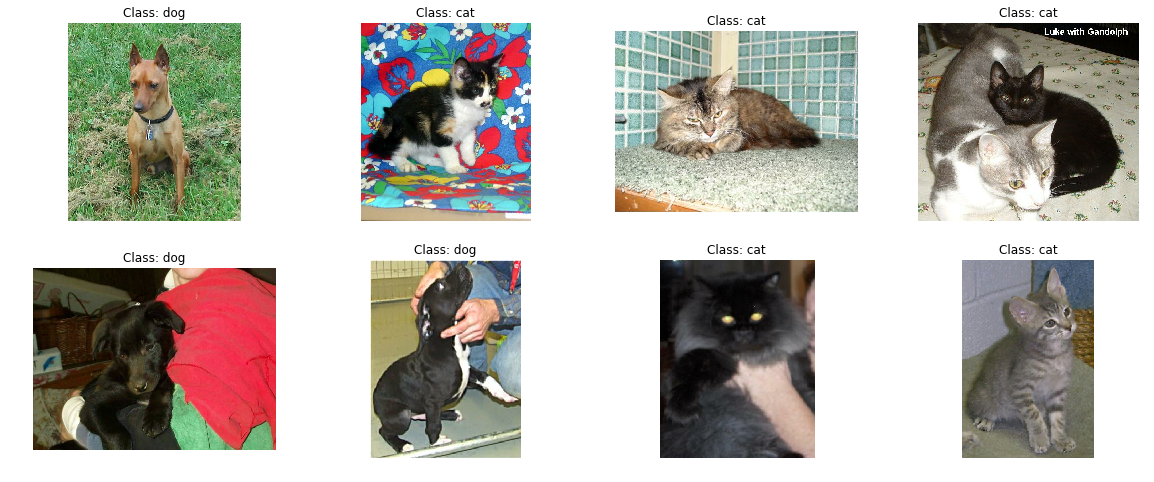

In [4]:
disp_examples = train_dataset.take(8)    
plt.subplots(2, 4, figsize=(20, 8))    
for i, x in enumerate(disp_examples):
    img = x[0].numpy()
    label = x[1].numpy()
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(f'Class: {label_map[label]}')
    plt.imshow(img)

## Creating tensorflow dataset objects, for train and test
 - prefetch batch to avoid performance bottle necks

In [5]:
def preprocess_map_func(image, label):
    image = tf.image.resize(image, size=[299, 299])
    return preprocess_input(image), label

train_dataset = train_dataset.map(lambda item1, item2:tf.numpy_function(preprocess_map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(lambda item1, item2:tf.numpy_function(preprocess_map_func, [item1, item2], [tf.float32, tf.int64]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(1024).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

W0405 13:31:51.802148 139847415195456 deprecation.py:323] From /home/mia/tensorflow2.0/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## Building the model
 - We select the pretrained Xception model available in keras applications package
 - The last layers is removed and a new fully connected layers is added with units=num_classes (here 2)
 - The base xception model is frozen(not to be trained), only the last classification layer is trained (transfer learning)
 - No finetuning required as the dataset is very similary to Imagenet2012

In [6]:
class Classifier(tf.keras.Model):
    def __init__(self):
        super(Classifier, self).__init__()
        self.base_model = Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
        self.average_pool = GlobalAveragePooling2D()
        self.fc = Dense(units=1, activation='linear', kernel_initializer='he_normal')
        self.base_model.trainable = False
        
    def call(self, inputs, training=False):
        y = self.base_model(inputs)
        y = self.average_pool(y)
        logits = self.fc(y)
        return logits

# Defining training loop and other necessary functions
 - Use of  the tf.function() decorator to convert training and evaluation functions into tensorflow graphs
 - Use of tf.GradientTape() for automatic differentiation 

In [7]:
loss_object = tf.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_accuracy = tf.keras.metrics.BinaryAccuracy()
valid_accuracy = tf.keras.metrics.BinaryAccuracy()

def loss_function(y_true, y_pred):
    loss = loss_object(y_true, y_pred)
    return tf.reduce_mean(loss)

def accuracy_function(y_true, y_pred):
    y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), 'int64')
    correct = tf.cast(tf.equal(y_true, y_pred), 'int64')
    correct = tf.reduce_sum(correct)
    return correct / y_true.shape[0]

@tf.function
def training_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor, training=True)
        loss = loss_function(label_tensor, logits)
        acc = train_accuracy(label_tensor, logits)
    gradients = Tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

@tf.function
def evaluation_step(input_tensor, label_tensor):
    with tf.GradientTape() as Tape:
        logits = model(input_tensor)
        acc = valid_accuracy(label_tensor, logits)
    return acc

## Running the tranining loop

In [8]:
epochs = 1
loss_array = []
acc_array = []

model = Classifier()
for epoch in range(epochs):        
    for step, example in enumerate(train_dataset):
        img_tensor = example[0]
        label_tensor = tf.reshape(example[1], shape=[-1, 1])
        loss, acc = training_step(img_tensor, label_tensor)
        loss_array.append(loss)
        acc_array.append(acc)
        if step % 150 == 0:
            print(f'| Loss at epoch_{epoch} step_{step} : {loss:.4f} |', f'acc : {acc:.3f} |')
model.save_weights('model_weights.h5')

| Loss at epoch_0 step_0 : 0.7252 | acc : 0.375 |
| Loss at epoch_0 step_150 : 0.4550 | acc : 0.531 |
| Loss at epoch_0 step_300 : 0.2721 | acc : 0.691 |
| Loss at epoch_0 step_450 : 0.2080 | acc : 0.781 |
| Loss at epoch_0 step_600 : 0.1668 | acc : 0.832 |
| Loss at epoch_0 step_750 : 0.1922 | acc : 0.862 |
| Loss at epoch_0 step_900 : 0.0953 | acc : 0.884 |
| Loss at epoch_0 step_1050 : 0.0867 | acc : 0.900 |
| Loss at epoch_0 step_1200 : 0.0732 | acc : 0.911 |
| Loss at epoch_0 step_1350 : 0.0741 | acc : 0.920 |
| Loss at epoch_0 step_1500 : 0.0759 | acc : 0.927 |
| Loss at epoch_0 step_1650 : 0.0552 | acc : 0.933 |
| Loss at epoch_0 step_1800 : 0.0711 | acc : 0.938 |
| Loss at epoch_0 step_1950 : 0.0599 | acc : 0.942 |
| Loss at epoch_0 step_2100 : 0.0412 | acc : 0.945 |
| Loss at epoch_0 step_2250 : 0.0420 | acc : 0.949 |
| Loss at epoch_0 step_2400 : 0.0297 | acc : 0.951 |


## Plotting train  loss

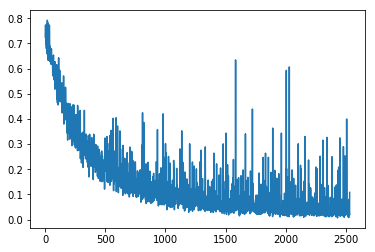

In [9]:
plt.plot(loss_array)

## Running the evaluation loop

In [12]:
val_acc_array = []
for step, example in enumerate(test_dataset):
    img_tensor = example[0]
    label_tensor = tf.reshape(example[1], shape=[-1, 1])
    acc = evaluation_step(img_tensor, label_tensor)
    val_acc_array.append(acc)
mean_accuracy = np.mean(val_acc_array)
print(f'| Validation accuracy : {mean_accuracy:.3f} |')

| Validation accuracy : 0.992 |


## Visualizing results

W0405 13:34:15.056524 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.093105 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.133562 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.169585 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.205951 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.242135 139847415195456 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 13:34:15.278700 139847

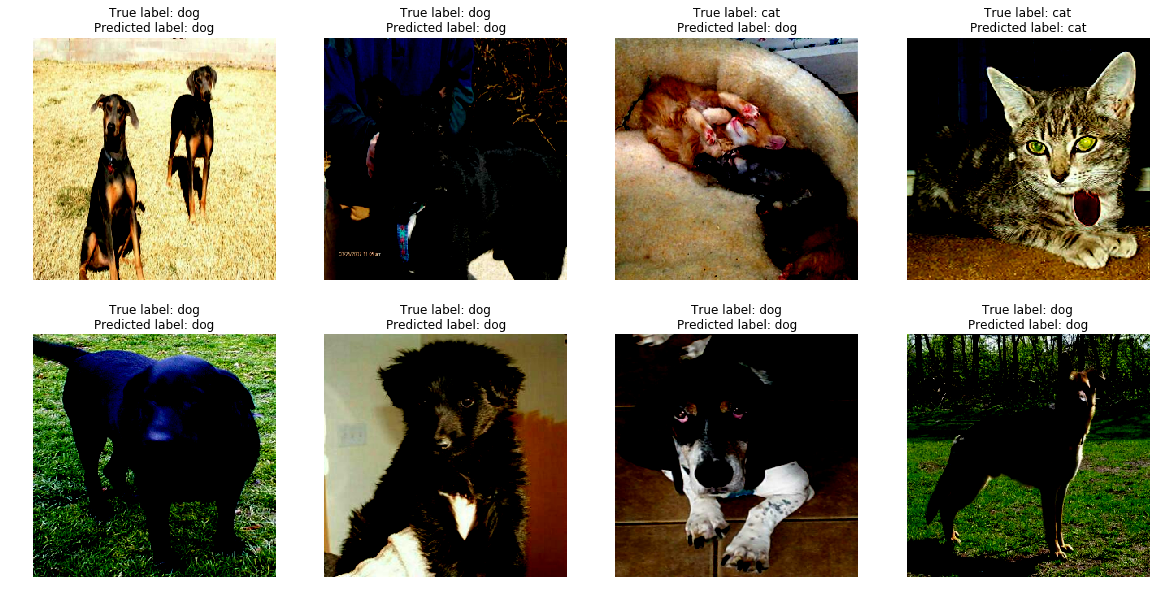

In [11]:
disp_examples = test_dataset.take(1)    
plt.subplots(2, 4, figsize=(20, 10))    
for x in disp_examples:
    images = x[0].numpy()
    labels = x[1].numpy()
    for i, img in enumerate(images[:10]):
        pred_prob = tf.sigmoid(model(tf.expand_dims(img, axis=0)))[0]
        pred = label_map[1] if pred_prob >= 0.5 else label_map[0]
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(f'True label: {label_map[labels[i]]}\nPredicted label: {pred}', wrap=True)
        plt.imshow(img)
    break